In [4]:
import os
import sys

# Get the current working directory (where your notebook is running)
script_dir = os.getcwd()

# Go one level up
parent_dir = os.path.abspath(os.path.join(script_dir, os.pardir))

# Insert the parent directory into Python path
sys.path.insert(0, parent_dir)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from env.pcm_storage import hp_system
from mpl_toolkits.mplot3d import Axes3D  # enables 3D plotting
from sklearn.linear_model import LinearRegression

In [15]:
def solve_rpm_and_eer(Q_cool, dt, T_cond, hp):
    """
    Given:
      Q_cool (kWh)  : Total cooling provided in time dt
      dt (s)        : Duration of the interval in seconds
      T_cond (°C)   : Condenser temperature
      hp            : An object with attributes:
                      hp.Q_intercept, hp.a, hp.b, hp.c, hp.d,
                      hp.EER_intercept, hp.e, hp.f, hp.g, hp.h
    
    Returns:
      (e, EER)
      where e is the electrical energy (kWh) used over dt,
            EER is the dimensionless energy-efficiency ratio.
    """
    # 1) Compute Q_dot_cool (kW)
    Q_dot_cool = Q_cool * 3600.0 / dt  # kW

    # 2) Solve for rpm from the polynomial:
    #    c*rpm^2 + a*rpm + (Q_intercept + b*T_cond + d*T_cond^2 - Q_dot_cool) = 0
    A = hp.c
    B = hp.a
    C = (hp.Q_intercept 
         + hp.b * T_cond 
         + hp.d * (T_cond ** 2) 
         - Q_dot_cool)

    # Handle the case where A is nearly 0 (degenerate quadratic => linear)
    if abs(A) < 1e-12:
        if abs(B) < 1e-12:
            raise ValueError("Both c and a are ~0, cannot solve.")
        rpm_candidate = -C / B
        if rpm_candidate <= 0:
            raise ValueError("No positive RPM solution found in linear case.")
        rpm = rpm_candidate
    else:
        # Solve the quadratic equation for rpm
        disc = B**2 - 4*A*C
        if disc < 0:
            # If the discriminant is negative, then set rpm and EER to 0
            return 0, 0

        sqrt_disc = math.sqrt(disc)
        rpm1 = (-B + sqrt_disc) / (2*A)
        rpm2 = (-B - sqrt_disc) / (2*A)

        # Filter for physically valid (positive) solutions
        candidates = [r for r in (rpm1, rpm2) if r > 0]
        if not candidates:
            raise ValueError("No positive RPM solution found.")
        rpm = candidates[0]
    
    # 3) Compute EER with the solved rpm
    EER = (hp.EER_intercept
           + hp.e * rpm
           + hp.f * T_cond
           + hp.g * (rpm ** 2)
           + hp.h * (T_cond ** 2))
    
    # If EER is zero, avoid division by zero; otherwise compute e.
    if EER == 0:
        e = 0
    else:
        e = Q_cool / EER

    return e, EER

In [16]:
def add_e_and_eer_columns(df, hp, load_col='load', T_cond_col='T_cond', rpm_col='rpm'):
    """
    Given a DataFrame with columns for load (Q_cool in kWh), T_cond (condenser temperature in °C),
    and rpm (operating rpm), compute the EER and electrical energy consumption e for each row.
    
    The EER is computed via:
    
        EER = hp.EER_intercept + hp.e * rpm + hp.f * T_cond + hp.g * rpm**2 + hp.h * T_cond**2
        
    and the electrical energy is:
    
        e = Q_cool / EER   (with a safeguard if EER is zero)
    
    Parameters:
      df        : Pandas DataFrame containing the required columns.
      hp        : An object with attributes:
                     hp.EER_intercept, hp.e, hp.f, hp.g, hp.h.
      load_col  : Name of the column with Q_cool (in kWh). Default is 'load'.
      T_cond_col: Name of the column with T_cond (°C). Default is 'T_cond'.
      rpm_col   : Name of the column with rpm. Default is 'rpm'.
    
    Returns:
      The DataFrame with two new columns: 'e' and 'EER'.
    """
    def compute_row_values(row):
        # Extract the required values from the row
        rpm = row[rpm_col]
        T_cond = row[T_cond_col]
        Q_cool = row[load_col]  # Q_cool in kWh
        
        # Compute EER using the polynomial correlation
        EER = (hp.EER_intercept +
               hp.e * rpm +
               hp.f * T_cond +
               hp.g * (rpm ** 2) +
               hp.h * (T_cond ** 2))
        
        # Avoid division by zero: if EER is zero, set e to zero.
        e = Q_cool / EER if EER != 0 else 0
        
        return pd.Series({'e': e, 'EER': EER})
    
    # Apply the row-wise computation and assign new columns
    df[['e', 'EER']] = df.apply(compute_row_values, axis=1, result_type='expand')

    return df

Benchmark_1H

In [17]:
total_df = pd.read_pickle(os.path.join(parent_dir, 'data', 'total_df.pkl'))
hp_15T = hp_system(dt=900)   # Initialize the HP system
baseline_15T = pd.DataFrame()

dt = 900

# Use DataFrame.apply with a lambda that calls solve_rpm_and_eer
baseline_15T[['e', 'EER']] = total_df.apply(
    lambda row: solve_rpm_and_eer(row['load'], dt, row['outdoor_temp'], hp_15T),
    axis=1,
    result_type='expand'
)

baseline_15T.to_pickle('./baseline_15T.pkl')

In [18]:
total_df_hourly = pd.read_pickle(os.path.join(parent_dir, 'data', 'total_df_hourly.pkl'))
hp_1H = hp_system(dt=3600)   # Initialize the HP system
baseline_1H = pd.DataFrame()

dt = 3600

# Use DataFrame.apply with a lambda that calls solve_rpm_and_eer
baseline_1H[['e', 'EER']] = total_df_hourly.apply(
    lambda row: solve_rpm_and_eer(row['load'], dt, row['outdoor_temp'], hp_1H),
    axis=1,
    result_type='expand'
)

baseline_1H.to_pickle('./baseline_1H.pkl')

Results analysis

In [19]:
df_results_1H = pd.read_pickle('./results_1H.pkl')
df_results_15T = pd.read_pickle('./results_15T.pkl')

In [20]:
# Calculate electricity consumption (e) and EER
df_results_15T = add_e_and_eer_columns(df_results_15T, hp_15T, load_col='load', T_cond_col='outdoor_temp', rpm_col='rpm')
df_results_1H = add_e_and_eer_columns(df_results_1H, hp_1H, load_col='load', T_cond_col='outdoor_temp', rpm_col='rpm')

In [21]:
df_results_15T.to_csv('./results_15T.csv')
df_results_1H.to_csv('./results_1H.csv')
baseline_1H.to_csv('./baseline_1H.csv')
baseline_15T.to_csv('./baseline_15T.csv')


<Axes: >

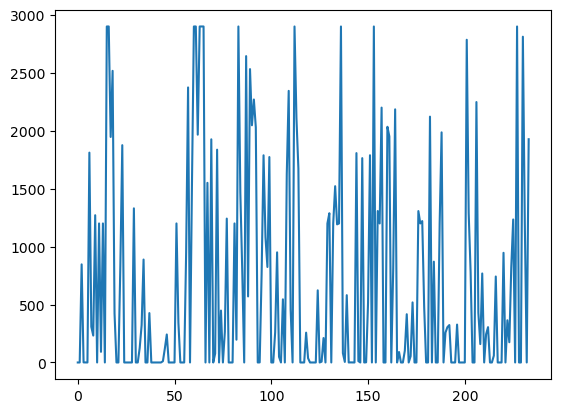

In [22]:
df_results_1H['rpm'].plot()

<Axes: >

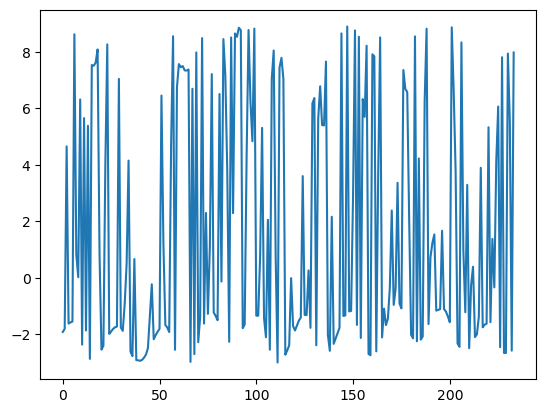

In [23]:
df_results_1H['EER'].plot()

Q_dot_cool Linear Regression Metrics:
  Mean Squared Error (MSE): 0.027145240342471823
  R^2 Score: 0.9854358941000003
  RMSE Score: 0.1647581267873358

EER Linear Regression Metrics:
  Mean Squared Error (MSE): 0.19930633244393667
  R^2 Score: 0.941311826693583
  RMSE Score: 0.4464373779646331


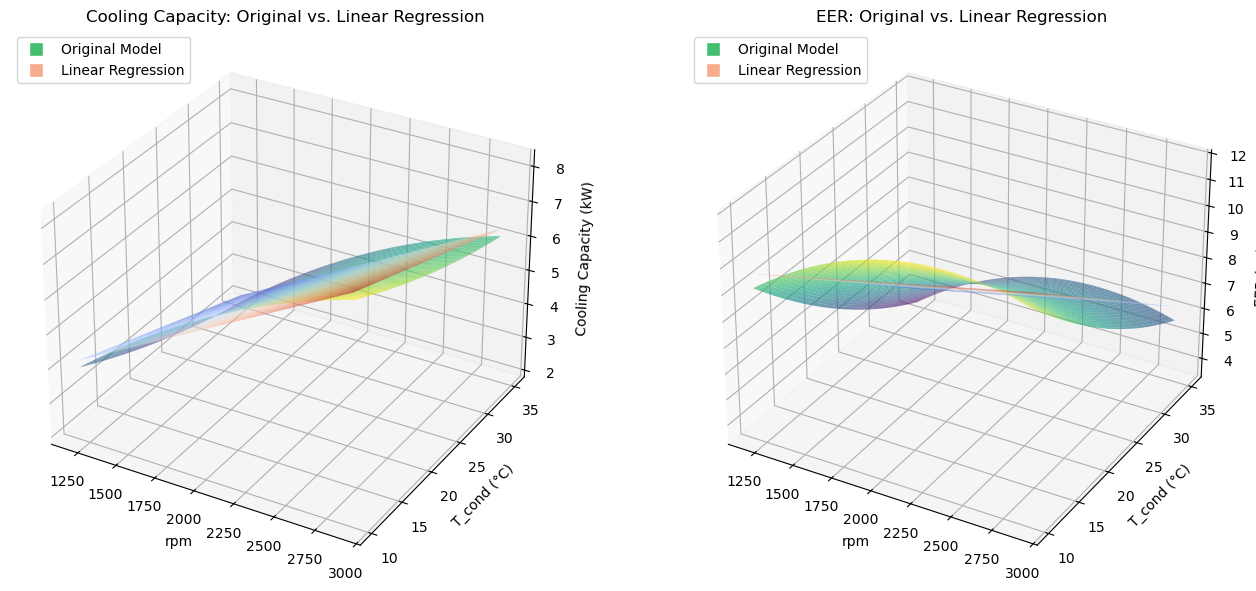

In [14]:
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

# Given coefficients for cooling capacity Q_dot_cool
Q_intercept = -0.2071864002858792
a = 0.005333811621408454      # coefficient for rpm
b = -0.1365379343864041        # coefficient for T_cond
c = -7.001133469771883e-07      # coefficient for rpm^2
d = 0.0012415247870363416       # coefficient for T_cond^2

# Coefficients for the HP EER correlation (unitless)
EER_intercept = 4.421297840489518
e = 0.009091070826281583       # coefficient for rpm
f = -0.38184371581722676       # coefficient for T_cond
g = -1.8923608336165108e-06     # coefficient for rpm^2
h = 0.003420273670974565       # coefficient for T_cond^2

# Define a grid of operating conditions
# Let's choose rpm between 1200 and 2900, and T_cond between 10°C and 35°C
rpm_range = np.linspace(1200, 2900, 100)
T_cond_range = np.linspace(10, 35, 100)
RPM, T_cond = np.meshgrid(rpm_range, T_cond_range)

# Original quadratic models for Q_dot_cool and EER
def Q_dot_cool_original(rpm, T_cond):
    return Q_intercept + a*rpm + b*T_cond + c*rpm**2 + d*T_cond**2

def EER_original(rpm, T_cond):
    return EER_intercept + e*rpm + f*T_cond + g*rpm**2 + h*T_cond**2

# Compute the original model values over the grid
Q_orig = Q_dot_cool_original(RPM, T_cond)
EER_orig = EER_original(RPM, T_cond)

# Prepare data for multiple linear regression
# Our independent variables are rpm and T_cond (only linear terms)
X = np.column_stack((RPM.ravel(), T_cond.ravel()))
y_Q = Q_orig.ravel()
y_EER = EER_orig.ravel()

# Fit a linear regression model for Q_dot_cool
model_Q = LinearRegression()
model_Q.fit(X, y_Q)
y_Q_pred = model_Q.predict(X)
Q_pred = y_Q_pred.reshape(RPM.shape)

# Fit a linear regression model for EER
model_EER = LinearRegression()
model_EER.fit(X, y_EER)
y_EER_pred = model_EER.predict(X)
EER_pred = y_EER_pred.reshape(RPM.shape)

# Calculate performance metrics for Q_dot_cool
mse_Q = mean_squared_error(y_Q, y_Q_pred)
r2_Q = r2_score(y_Q, y_Q_pred)
rmse_Q = root_mean_squared_error(y_Q, y_Q_pred)

# Calculate performance metrics for EER
mse_EER = mean_squared_error(y_EER, y_EER_pred)
r2_EER = r2_score(y_EER, y_EER_pred)
rmse_EER = root_mean_squared_error(y_EER, y_EER_pred)

print("Q_dot_cool Linear Regression Metrics:")
print("  Mean Squared Error (MSE):", mse_Q)
print("  R^2 Score:", r2_Q)
print("  RMSE Score:", rmse_Q)
print("")
print("EER Linear Regression Metrics:")
print("  Mean Squared Error (MSE):", mse_EER)
print("  R^2 Score:", r2_EER)
print("  RMSE Score:", rmse_EER)

# Plot the surfaces: original quadratic model vs. linear regression approximation
fig = plt.figure(figsize=(14, 6))

# Cooling Capacity plot
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(RPM, T_cond, Q_orig, cmap='viridis', alpha=0.7)
surf2 = ax1.plot_surface(RPM, T_cond, Q_pred, cmap='coolwarm', alpha=0.7)
ax1.set_xlabel('rpm')
ax1.set_ylabel('T_cond (°C)')
ax1.set_zlabel('Cooling Capacity (kW)')
ax1.set_title('Cooling Capacity: Original vs. Linear Regression')
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label='Original Model',
           markerfacecolor=cm.viridis(0.7), markersize=10),
    Line2D([0], [0], marker='s', color='w', label='Linear Regression',
           markerfacecolor=cm.coolwarm(0.7), markersize=10)
]
ax1.legend(handles=legend_elements, loc='upper left')

# EER plot
ax2 = fig.add_subplot(122, projection='3d')
surf3 = ax2.plot_surface(RPM, T_cond, EER_orig, cmap='viridis', alpha=0.7)
surf4 = ax2.plot_surface(RPM, T_cond, EER_pred, cmap='coolwarm', alpha=0.7)
ax2.set_xlabel('rpm')
ax2.set_ylabel('T_cond (°C)')
ax2.set_zlabel('EER (unitless)')
ax2.set_title('EER: Original vs. Linear Regression')
ax2.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()